**Preliminary Model**

In [ ]:
# Load in libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms, models
import torch
import torch.nn as nn
import torch.optim as optim
import random
import shutil
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib.image import imread
import os
from imageio import imread
from sklearn.metrics import classification_report, confusion_matrix
import torch.nn.functional as F
from collections import Counter

# Stopping warnings
import warnings
warnings.filterwarnings('ignore')

In [ ]:
#from google.colab import drive
#drive.mount('/content/drive')
#!unzip /content/drive/MyDrive/dataset.zip -d /content/dataset
#path = '/content/dataset/dataset'

In [5]:
# Load data
width = []
height = []
channel_color = []
weather_type = []

path = './dataset'

for folder in os.listdir(path):
    subfolder_path = os.path.join(path, folder) 

    if not os.path.isdir(subfolder_path):
        continue

    for image_file in os.listdir(subfolder_path):
        image_path = os.path.join(subfolder_path, image_file)

        if os.path.isdir(image_path):
            continue

        image = imread(image_path)

        # handling any grayscale images
        if len(image.shape) < 3:
            image = image.reshape(image.shape + (1,))

        h, w, c = image.shape
        width.append(h)      
        height.append(w)     
        channel_color.append(c)
        weather_type.append(folder) 

# create DataFrame
df = pd.DataFrame({
    'width': width,
    'height': height,
    'channels': channel_color,
    'weather': weather_type
})

df.head()

,width,height,channels,weather
0,283,400,3,lightning
1,300,400,3,lightning
2,264,400,3,lightning
3,188,378,3,lightning
4,238,284,3,lightning


In [24]:
## Further Preprocessing !
transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5,0.5,0.5], std=[0.5,0.5,0.5])
])

# Set to your correct dataset path!!
dataset = datasets.ImageFolder('./dataset', transform=transform)

# printing class names
print("Classes:", dataset.classes)

# printing number of images per class
labels = [label for _, label in dataset]
counts = Counter(labels)
print("Images per class:", counts)

Classes: ['dew', 'fogsmog', 'frost', 'glaze', 'hail', 'lightning', 'rain', 'rainbow', 'rime', 'sandstorm', 'snow']
Images per class: Counter({8: 1160, 1: 851, 0: 698, 9: 692, 3: 639, 10: 621, 4: 591, 6: 526, 2: 475, 5: 377, 7: 232})


In [25]:
print(dataset.classes)


['dew', 'fogsmog', 'frost', 'glaze', 'hail', 'lightning', 'rain', 'rainbow', 'rime', 'sandstorm', 'snow']


In [14]:


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# Transforms
transform = transforms.Compose([
    transforms.Resize((64, 64)),   # resize images
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

# Load dataset

#Set to your correct dataset path!!
dataset = datasets.ImageFolder('./dataset', transform=transform)

num_classes = len(dataset.classes)
print("Classes:", dataset.classes)


#Train and Validation split
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32)


#CNN
class SimpleCNN(nn.Module):
    def __init__(self, num_classes):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, 3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(16, 32, 3, padding=1)
        self.fc1 = nn.Linear(32 * 16 * 16, 128)
        self.fc2 = nn.Linear(128, num_classes)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 32 * 16 * 16)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

model = SimpleCNN(num_classes).to(device)

# Setting Loss criterion and Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
train_losses = []

epochs = 5
for epoch in range(epochs):
    model.train()
    running_loss = 0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    avg_loss = running_loss / len(train_loader)
    train_losses.append(avg_loss)
    print(f"Epoch {epoch+1}/{epochs}, Loss: {avg_loss:.4f}")

# Validation
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for images, labels in val_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print("Validation Accuracy: {:.2f}%".format(100 * correct / total))

Using device: cpu
Classes: ['dew', 'fogsmog', 'frost', 'glaze', 'hail', 'lightning', 'rain', 'rainbow', 'rime', 'sandstorm', 'snow']
Epoch 1/5, Loss: 1.3139
Epoch 2/5, Loss: 0.9618
Epoch 3/5, Loss: 0.8349
Epoch 4/5, Loss: 0.7267
Epoch 5/5, Loss: 0.6346
Validation Accuracy: 68.03%


Graphics

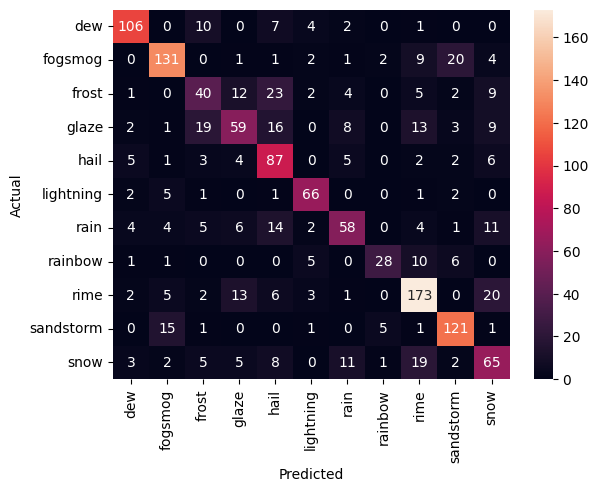

In [15]:
## Confusion Matrix
all_labels = []
all_preds = []

model.eval()
with torch.no_grad():
    for images, labels in val_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(predicted.cpu().numpy())

cm = confusion_matrix(all_labels, all_preds)
sns.heatmap(cm, annot=True, fmt='d', xticklabels=dataset.classes, yticklabels=dataset.classes)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()



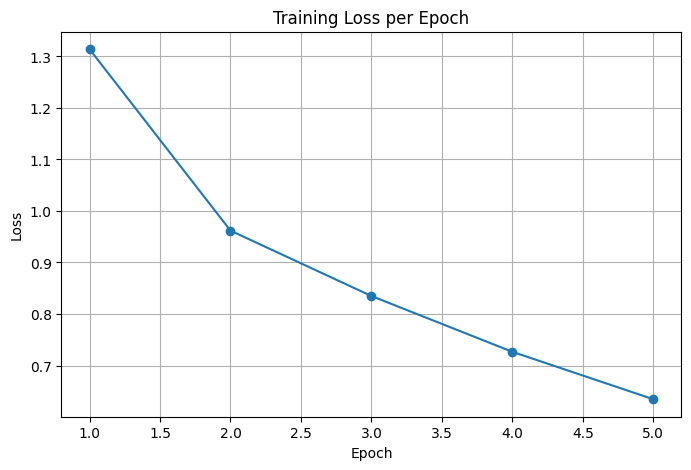

In [16]:
## Loss Curve
plt.figure(figsize=(8,5))
plt.plot(range(1, epochs+1), train_losses, marker='o')
plt.title("Training Loss per Epoch")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)
plt.show()


In [22]:
## metrics 
all_preds = []
all_labels = []

model.eval()
with torch.no_grad():
    for images, labels in val_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

report_dict = classification_report(all_labels, all_preds, target_names=dataset.classes, output_dict=True)
report_df = pd.DataFrame(report_dict).transpose()
keep_rows = list(dataset.classes) + ["accuracy"]
report_df_filtered = report_df.loc[keep_rows]

print(report_df_filtered)

           precision    recall  f1-score     support
dew         0.841270  0.815385  0.828125  130.000000
fogsmog     0.793939  0.766082  0.779762  171.000000
frost       0.465116  0.408163  0.434783   98.000000
glaze       0.590000  0.453846  0.513043  130.000000
hail        0.533742  0.756522  0.625899  115.000000
lightning   0.776471  0.846154  0.809816   78.000000
rain        0.644444  0.532110  0.582915  109.000000
rainbow     0.777778  0.549020  0.643678   51.000000
rime        0.726891  0.768889  0.747300  225.000000
sandstorm   0.761006  0.834483  0.796053  145.000000
snow        0.520000  0.537190  0.528455  121.000000
accuracy    0.680262  0.680262  0.680262    0.680262


In [23]:
# overall metrics --> using weighted avg to address class imbalance

report_dict = classification_report(all_labels, all_preds, output_dict=True)
report_df = pd.DataFrame(report_dict).transpose()

overall_metrics = report_df.loc['weighted avg', ['precision', 'recall', 'f1-score']]
overall_metrics['support'] = report_df.loc['weighted avg', 'support']

print(overall_metrics)


precision       0.681779
recall          0.680262
f1-score        0.676855
support      1373.000000
Name: weighted avg, dtype: float64
